<a href="https://www.kaggle.com/code/vanpatangan/mental-health-insight-sentiment-analysis?scriptVersionId=235844628" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/kaggle/input/mental-health-insights-vulnerable-cancer-patients/Mental Health Dataset.csv')

# EDA

In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [3]:
print("Data Summary")
display(check(df))
display(df.head())

Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,posts,object,10391,10391,1,0
1,predicted,object,10392,4,0,0
2,intensity,int64,10392,4,0,0


,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


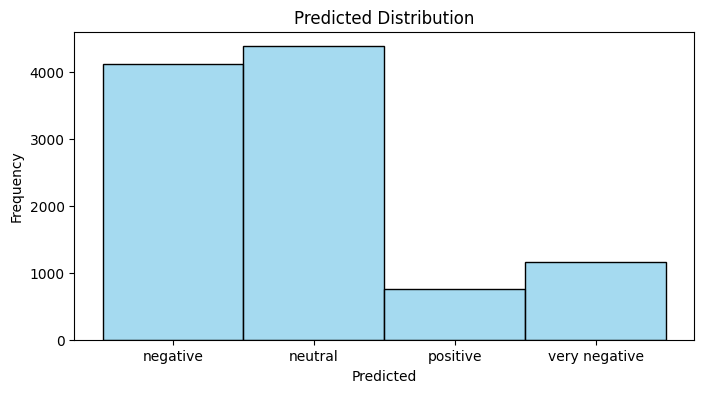

In [4]:
# Visualize predicted column 
predicted = df['predicted']
plt.figure(figsize=(8, 4))
# Plot a histogram
sns.histplot(predicted, bins=30, kde=False, color='skyblue')
plt.title('Predicted Distribution')
plt.xlabel('Predicted')
plt.ylabel('Frequency')
plt.show()

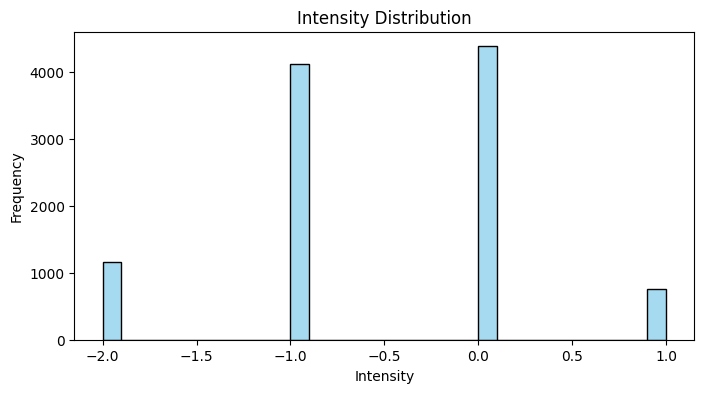

In [5]:
# Visualize intensity column 
intensity = df['intensity']
plt.figure(figsize=(8, 4))
# Plot a histogram
sns.histplot(intensity, bins=30, kde=False, color='skyblue')
plt.title('Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

# Preprocess

In [6]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# Drop rows where posts is null
df = df.dropna(subset=['posts'])

# Align row counts (keep only rows where all columns are present)
df = df.loc[df.index.isin(df[['posts', 'predicted', 'intensity']].dropna().index)]

# Label mapping 
label_map = {
    'positive': 0,
    'neutral': 1,
    'negative': 2,
    'very negative': 3 
}

# Preprocess text
def preprocess_text(text):
    text = str(text).lower()  # Convert to string and lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply preprocessing
df['posts_cleaned'] = df['posts'].apply(preprocess_text)

# Encode labels
df['label'] = df['predicted'].map(label_map)

# Modeling

In [7]:
# Split data
X = df['posts_cleaned']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use intensity as sample weights
intensity_weights = df.loc[X_train.index, 'intensity']

# TF-IDF + Logistic Regression
# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial')
model.fit(X_train_tfidf, y_train, sample_weight=intensity_weights)

# Evaluate
y_pred = model.predict(X_test_tfidf)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Results:
               precision    recall  f1-score   support

     positive       0.07      1.00      0.13       150
      neutral       0.00      0.00      0.00       875
     negative       0.00      0.00      0.00       823
very negative       0.00      0.00      0.00       231

     accuracy                           0.07      2079
    macro avg       0.02      0.25      0.03      2079
 weighted avg       0.01      0.07      0.01      2079



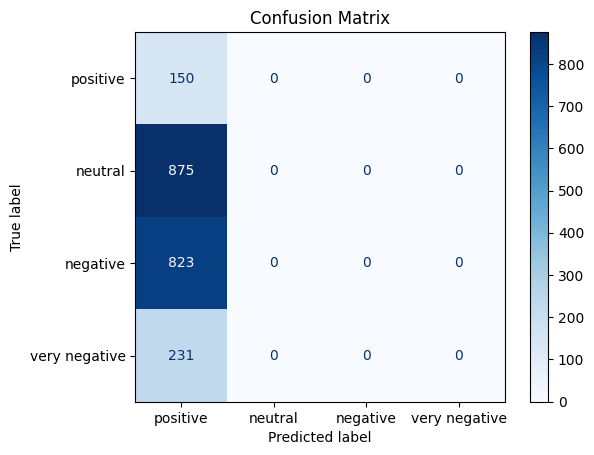

In [9]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()